In [1]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

d:\DATA\a.asri\doc-classifier


In [2]:
import json
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import load, dump
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from src import save_jsonfile, read_jsonfile

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier

# Chargement des datasets train et test

In [3]:
df_train = pd.read_csv('data/processed/words_structure_train.csv')
df_test = pd.read_csv('data/processed/words_structure_test.csv')
seed = 42

In [4]:
df_train['words'] = df_train['words'].fillna('')
df_test['words'] = df_test['words'].fillna('')

X_train = df_train.drop('category', axis=1)
y_train = df_train['category']
X_test = df_test.drop('category', axis=1)
y_test = df_test['category']

### LabelEncoder

In [5]:
le = load("models/target_LabelEncoder.joblib")
y_train = le.transform(y_train)
y_test = le.transform(y_test)

### Tf-idf Vectorizer

In [6]:
X_train_corpus = X_train['words'].tolist()
X_test_corpus = X_test['words'].tolist()

tfidf_vectorizer = load('models/TfidfVectorizer.joblib')

X_train_tfidf = tfidf_vectorizer.transform(X_train_corpus)
X_train_tfidf = X_train_tfidf.toarray()

X_test_tfidf = tfidf_vectorizer.transform(X_test_corpus)
X_test_tfidf = X_test_tfidf.toarray()

In [7]:
def calculate_accuracy(model, X_test: np.ndarray, y_test: np.ndarray) -> dict:
    cat_dict = {
        0: "email",
        1: "handwritten",
        2: "invoice",
        3: "national_identity_card",
        4: "passeport",
        5: "scientific_publication"
    }
    category_accuracies = {}
    y_pred = model.predict(X_test)
    category_accuracies['Global'] = accuracy_score(y_test, y_pred)

    categories = np.unique(y_test)
    for category in categories:
        mask = (y_test == category)
        category_accuracy = accuracy_score(y_test[mask], y_pred[mask])
        category_accuracies[cat_dict[category]] = category_accuracy

    return category_accuracies


def plot_search_results(cv_results: dict, best_params: dict, param_grid: dict, title: str) -> None:
    masks_names = [k for k, v in param_grid.items() if len(v) > 1]
    if not isinstance(cv_results, pd.DataFrame):
        cv_results = pd.DataFrame(cv_results)

    plot_results = {}
    for pk, pv in best_params.items():
        if pk not in masks_names:
            param_grid.pop(pk)
            continue
        plot_results[pk] = [[], [], []]
        for val in param_grid[pk]:
            if val != None:
                res_param = cv_results[cv_results[f'param_{pk}'] == val]
            else:
                res_param = cv_results.loc[cv_results[f'param_{pk}'].isnull()]

            id_ = res_param['mean_test_score'].idxmax()

            if pd.isna(id_):
                plot_results[pk][0].append(str(val))
                plot_results[pk][1].append(0.0)
                plot_results[pk][2].append(0.0)
            else:
                row = cv_results.iloc[id_]
                mean_test_score = row['mean_test_score']
                std_test_score = row['std_test_score']
                plot_results[pk][0].append(str(val))
                plot_results[pk][1].append(mean_test_score)
                plot_results[pk][2].append(std_test_score)

    ## Ploting results
    fig, ax = plt.subplots(1, len(plot_results), sharex='none', sharey='all', figsize=(20, 5))

    fig.suptitle(title+'\nScore per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    for i, [name, values] in enumerate(plot_results.items()):
        x = np.array(values[0])
        y_1 = np.array(values[1])
        e_1 = np.array(values[2])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(name.upper())
    plt.legend()
    plt.show()

# Grille de Paramètres 

In [8]:
models_param_grids = {
    "LogisticRegression": {
        'C': [100, 10],
        'solver': ['lbfgs'],
        'penalty': ['elasticnet', 'l2']
    },
    "NearestCentroid": {
        'metric': ['euclidean'],
        'shrink_threshold': [None, 0.5]
    },
    "ExtraTreesClassifier": {
        'criterion': ['gini', 'entropy'],
        'n_estimators': [100, 200],
        'max_depth': [None, 30],
        'min_samples_split': [2],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True],
        'oob_score': [True, False]
    },
    "RandomForestClassifier": {
        'criterion': ['gini', 'entropy'],
        'n_estimators': [200, 100, 500],
        'max_depth': [None, 30],
        'min_samples_split': [5],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True],
        'oob_score': [True, False]
    },
    "XGBClassifier": {
        'n_estimators': [200, 100, 300],
        'max_depth': [5],
        'learning_rate': [0.1],
        'gamma': [0.2],
        'reg_alpha': [0, 0.5],
        'reg_lambda': [0, 0.5]
    },
    "LGBMClassifier": {
        'boosting_type': ['gbdt', 'dart'],
        'n_estimators': [200, 100],
        'max_depth': [10, 5],
        'learning_rate': [0.1],
        'min_child_samples': [10, 50],
        'class_weight': [None, 'balanced'],
        'num_leaves': [31],
        'force_row_wise': [True],
        'force_col_wise': [False]
    }
}


class Encoder(json.JSONEncoder):
    def default(self, obj):

        # Polygon or array convert to list
        if isinstance(obj, (np.ndarray)):
            return obj.tolist()

        # int32 convert to int
        if isinstance(obj, (np.int32)):
            return int(obj)

        return super().default(obj)

# Recherche d'hyper paramètres avec GridSearchCV

In [10]:
cv = 5
scoring = 'accuracy'
verbose = 3
n_jobs = 5

data_results = {}
output_data_name = 'models/tfidifOnly_GridSearchCV_result.json'
data_results['seed'] = seed
data_results['GridSearchCV_params'] = {'cv':cv, 'scoring':scoring, 'verbose':verbose, 'n_jobs':n_jobs}
for model_name, param_grid in models_param_grids.items():

    print('\n', "="*100, '\n')
    print("Train:", model_name)
    print("Params Grid:", param_grid)
    data_results[model_name] = {}
    data_results[model_name]['param_grid'] = param_grid

    if model_name == "LogisticRegression":
        model = LogisticRegression(random_state=seed)
    elif model_name == "NearestCentroid":
        model = NearestCentroid()
    elif model_name == "ExtraTreesClassifier":
        model = ExtraTreesClassifier(random_state=seed)
    elif model_name == "LGBMClassifier":
        model = LGBMClassifier(objective='multiclass', random_state=seed)
    elif model_name == "XGBClassifier":
        model = XGBClassifier(objective='multi:softprob', seed=seed)
    elif model_name == "RandomForestClassifier":
        model = RandomForestClassifier(random_state=seed)

    t0 = time.time()
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=verbose)
    grid_search.fit(X_train_tfidf, y_train)
    GridSearchCV_training_time = time.time() - t0
    print("GridSearchCV - DONE in", GridSearchCV_training_time/60, "min")
    data_results[model_name]['GridSearchCV_time'] = GridSearchCV_training_time
    data_results[model_name]['best_params'] = grid_search.best_params_
    data_results[model_name]['cv_results'] = grid_search.cv_results_
    print("Best params:", grid_search.best_params_)

    accuracy = calculate_accuracy(grid_search.best_estimator_, X_test_tfidf, y_test)
    data_results[model_name]['accuracy'] = accuracy
    print("Accuracy:\n", accuracy)

    model_filename = f"tfidfOnly_{model_name}.joblib"
    data_results[model_name]['file_name'] = model_filename
    dump(grid_search.best_estimator_, os.path.join('models', model_filename))
    save_jsonfile(output_data_name, data_results, indent=4, cls=Encoder)
    print("Model saved:", os.path.join('models', model_filename))



Train: LogisticRegression
Params Grid: {'C': [100, 10], 'solver': ['lbfgs'], 'penalty': ['elasticnet', 'l2']}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


d:\DATA\a.asri\doc-classifier\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "d:\DATA\a.asri\doc-classifier\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\DATA\a.asri\doc-classifier\.venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\DATA\a.asri\doc-classifier\.venv\Lib\site-packages\sklearn\linear_model\_lo

GridSearchCV - DONE in 8.381604639689128 min
Best params: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy:
 {'Global': 0.869198312236287, 'email': 0.935361216730038, 'handwritten': 0.6814159292035398, 'invoice': 0.9124668435013262, 'national_identity_card': 0.5909090909090909, 'passeport': 0.9147286821705426, 'scientific_publication': 0.905511811023622}
Model saved: models\tfidfOnly_LogisticRegression.joblib


Train: NearestCentroid
Params Grid: {'metric': ['euclidean'], 'shrink_threshold': [None, 0.5]}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
GridSearchCV - DONE in 0.5951470971107483 min
Best params: {'metric': 'euclidean', 'shrink_threshold': None}
Accuracy:
 {'Global': 0.7559774964838256, 'email': 0.844106463878327, 'handwritten': 0.9469026548672567, 'invoice': 0.7771883289124668, 'national_identity_card': 0.5681818181818182, 'passeport': 0.42248062015503873, 'scientific_publication': 0.8346456692913385}
Model saved: models\tfidfOnly_NearestCentroid.joblib

KeyboardInterrupt: 

# Analyse de GridSearchCV

In [9]:
data_results = read_jsonfile('models/tfidfOnly_GridSearchCV_result.json')

D:\DATA\a.asri\AppData\Local\Temp\ipykernel_3844\2685201793.py:40: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  id_ = res_param['mean_test_score'].idxmax()


TypeError: 'Axes' object is not subscriptable

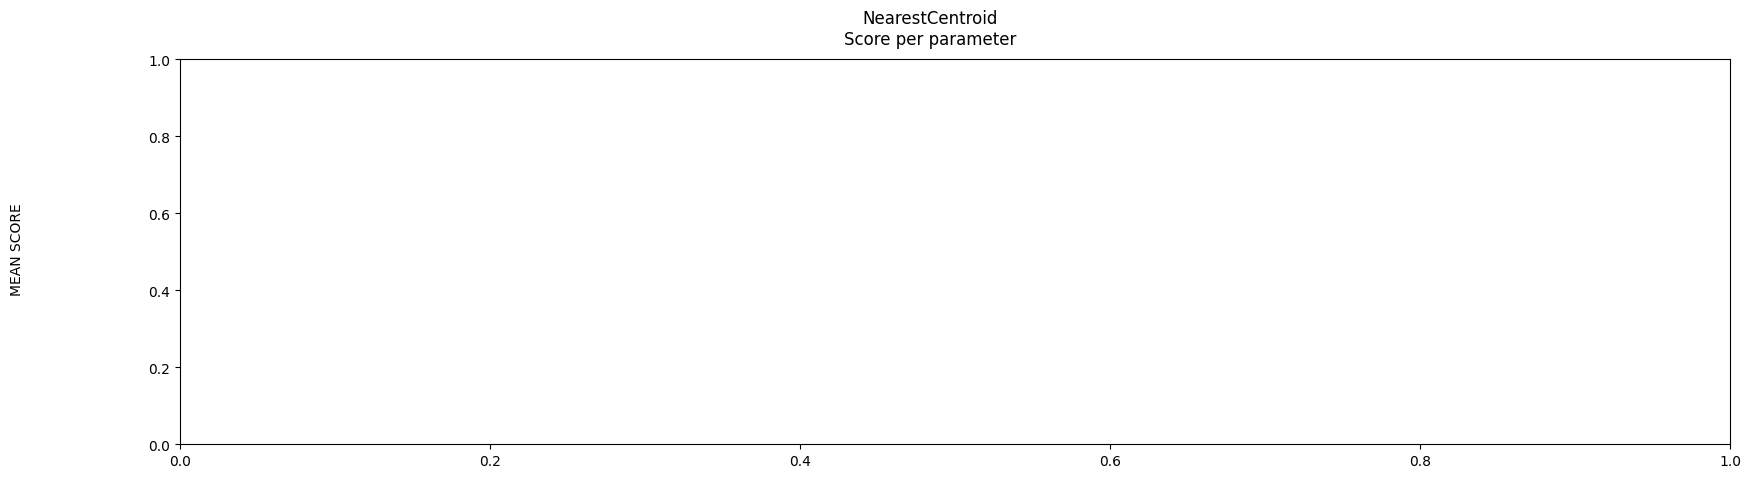

In [10]:
models = ['NearestCentroid', 'RandomForestClassifier', 'ExtraTreesClassifier', 'LGBMClassifier', 'LogisticRegression', 'XGBClassifier']
for model_name in models:
    model_result = copy.deepcopy(data_results[model_name])
    plot_search_results(model_result['cv_results'], model_result['best_params'], model_result['param_grid'], model_name)
    print("Best params:", model_result['best_params'])
    print("="*100)

# Analyse des meilleurs résultats

NameError: name 'values_LGBM' is not defined

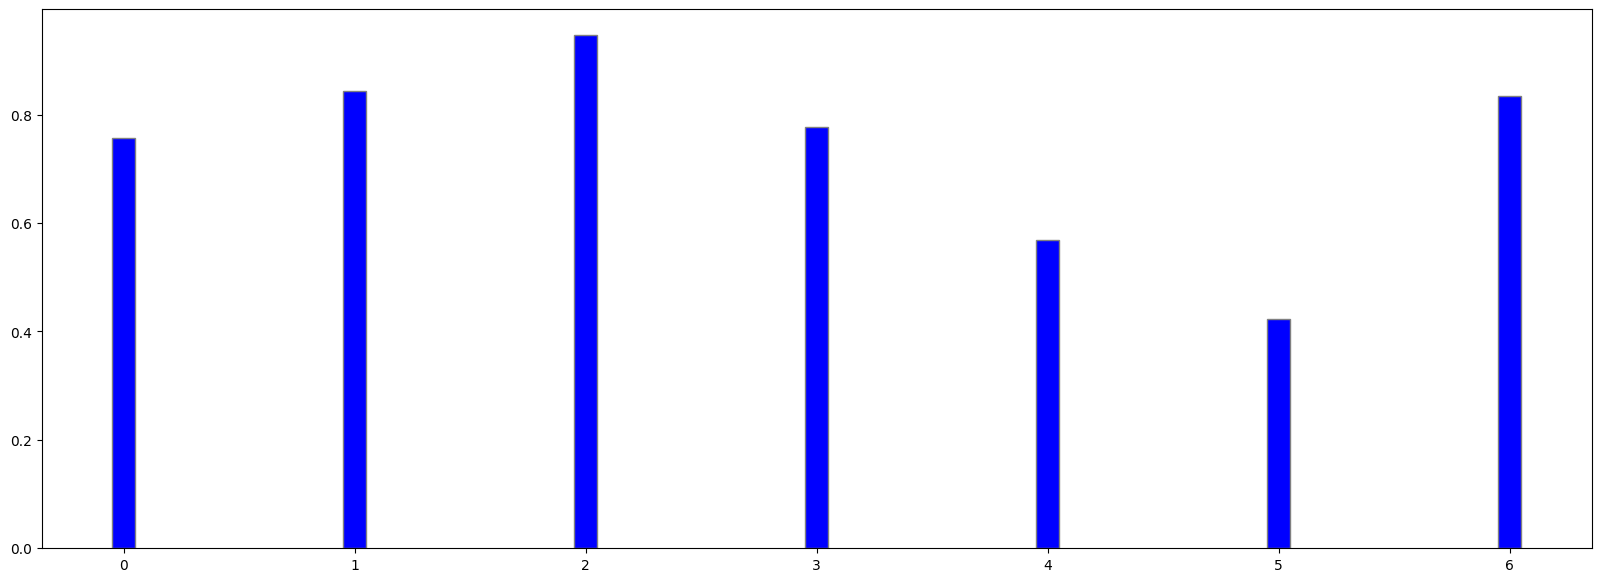

In [15]:
# Labels des catégories
categories = list(data_results['NearestCentroid']['accuracy'].keys())

# Valeurs d'accuracy pour chaque modèle
values_NearestCentroid = list(data_results['NearestCentroid']['accuracy'].values())
values_LGBM = list(data_results['LGBMClassifier']['accuracy'].values())
values_ExtraTrees = list(data_results['ExtraTreesClassifier']['accuracy'].values())
values_RandomForest = list(data_results['RandomForestClassifier']['accuracy'].values())
values_LogisticRegression = list(data_results['LogisticRegression']['accuracy'].values())
values_XGB = list(data_results['XGBClassifier']['accuracy'].values())

# Largeur des barres
bar_width = 0.1

# Positions des barres sur l'axe x
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Création du graphique
plt.figure(figsize=(20, 7))
plt.bar(r1, values_NearestCentroid, color='b', width=bar_width, edgecolor='grey', label='NearestCentroid')
plt.bar(r2, values_LGBM, color='g', width=bar_width, edgecolor='grey', label='LGBM')
plt.bar(r3, values_ExtraTrees, color='r', width=bar_width, edgecolor='grey', label='ExtraTrees')
plt.bar(r4, values_RandomForest, color='y', width=bar_width, edgecolor='grey', label='RandomForest')
plt.bar(r5, values_LogisticRegression, color='m', width=bar_width, edgecolor='grey', label='LogisticRegression')
plt.bar(r6, values_XGB, color='c', width=bar_width, edgecolor='grey', label='XGBClassifier')

plt.xlabel('Catégories', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(categories))], categories)
plt.ylabel('Accuracy')
plt.title('Accuracy de modèles par catégorie')

plt.legend()
plt.ylim(0.45,1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('LogisticRegression', load('models/tfidfOnly_LogisticRegression.joblib')),
    ('RandomForest', load('models/tfidfOnly_RandomForestClassifier.joblib')),
    ('ExtraTrees', load('models/tfidfOnly_ExtraTreesClassifier.joblib')),
    ('LGBM', load('models/tfidfOnly_LGBMClassifier.joblib')),
    ('XGB', load('models/tfidfOnly_XGBClassifier.joblib')),
]

voting_hard = VotingClassifier(estimators, voting='hard', n_jobs=16)
voting_soft = VotingClassifier(estimators, voting='soft', n_jobs=16)

voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71385
[LightGBM] [Info] Number of data points in the train set: 5687, number of used features: 2654
[LightGBM] [Info] Start training from score -1.751268
[LightGBM] [Info] Start training from score -1.714466
[LightGBM] [Info] Start training from score -1.406723
[LightGBM] [Info] Start training from score -3.648726
[LightGBM] [Info] Start training from score -1.608032
[LightGBM] [Info] Start training from score -1.742191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/data/dhryniewski/DataScientest/doc-classifier/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71385
[LightGBM] [Info] Number of data points in the train set: 5687, number of used features: 2654
[LightGBM] [Info] Start training from score -1.751268
[LightGBM] [Info] Start training from score -1.714466
[LightGBM] [Info] Start training from score -1.406723
[LightGBM] [Info] Start training from score -3.648726
[LightGBM] [Info] Start training from score -1.608032
[LightGBM] [Info] Start training from score -1.742191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/data/dhryniewski/DataScientest/doc-classifier/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=100, random_state=42)),
                             ('RandomForest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features='log2',
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     oob_score=True,
                                                     random_state=42)),
                             ('ExtraTrees',
                              ExtraTreesClassifier(bootstrap=True,
                                                   criterion='entropy',
                                                   max_features='log2',
                                                   min_samples_split...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 n_jobs=16, voting='soft')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


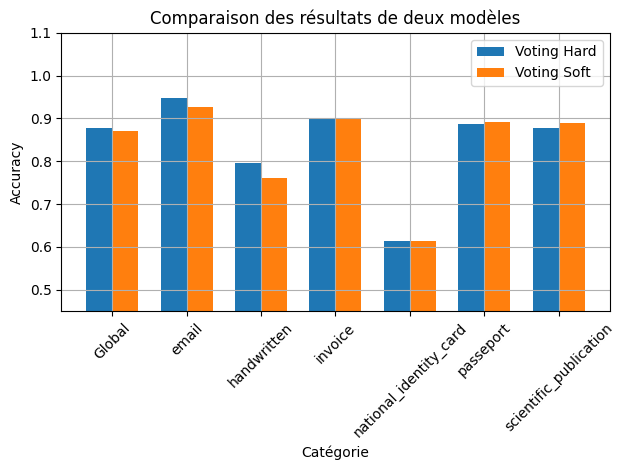

In [ ]:
accuracy_voting_hard = calculate_accuracy(voting_hard, X_test, y_test)
accuracy_voting_soft = calculate_accuracy(voting_soft, X_test, y_test)


categories = list(accuracy_voting_hard.keys())
accuracy_hard = list(accuracy_voting_hard.values())
accuracy_soft = list(accuracy_voting_soft.values())

x = range(len(categories))
width = 0.35

plt.bar(x, accuracy_hard, width, label='Voting Hard')
plt.bar([i + width for i in x], accuracy_soft, width, label='Voting Soft')

plt.xlabel('Catégorie')
plt.ylabel('Accuracy')
plt.title('Comparaison des résultats de deux modèles')
plt.xticks([i + width/2 for i in x], categories, rotation=45)
plt.legend()
plt.ylim(0.45,1.1)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
model_vc_name = "tfidfOnly_VotingClassifier.joblib"
dump(voting_hard, os.path.join('models', model_vc_name))

['models/words_structure_VotingClassifier.joblib']

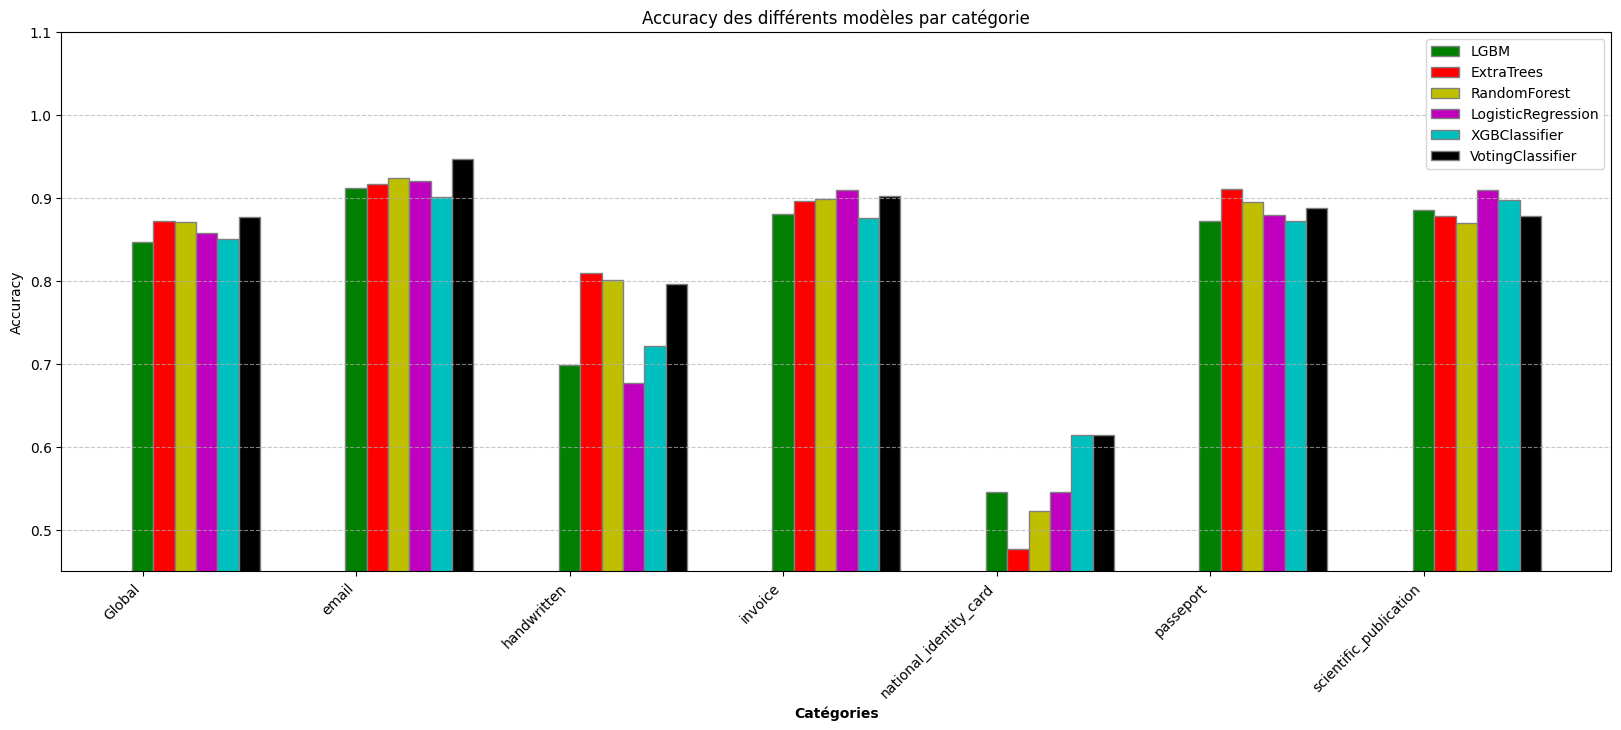

In [ ]:
values_voting_hard = list(accuracy_voting_hard.values())

r7 = [x + bar_width for x in r6]

# Création du graphique
plt.figure(figsize=(20, 7))
#plt.bar(r1, values_NearestCentroid, color='b', width=bar_width, edgecolor='grey', label='NearestCentroid')
plt.bar(r2, values_LGBM, color='g', width=bar_width, edgecolor='grey', label='LGBM')
plt.bar(r3, values_ExtraTrees, color='r', width=bar_width, edgecolor='grey', label='ExtraTrees')
plt.bar(r4, values_RandomForest, color='y', width=bar_width, edgecolor='grey', label='RandomForest')
plt.bar(r5, values_LogisticRegression, color='m', width=bar_width, edgecolor='grey', label='LogisticRegression')
plt.bar(r6, values_XGB, color='c', width=bar_width, edgecolor='grey', label='XGBClassifier')
plt.bar(r7, values_voting_hard, color='k', width=bar_width, edgecolor='grey', label='VotingClassifier')

plt.xlabel('Catégories', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(categories))], categories)
plt.ylabel('Accuracy')
plt.title('Accuracy des différents modèles par catégorie')

plt.legend()
plt.ylim(0.45,1.1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()